In [1]:
!conda install -y gdown

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    filelock-3.0.12            |     pyh9f0ad1d_0          10 KB  conda-forge
    gdown-3.12.2               |     pyh9f0ad1d_0          12 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          22 KB

The following NEW packages will be INSTALLED:

  filelock           conda-forge/noarch::filelock-3.0.12-pyh9f0ad1d_0
  gdown              conda-forge/noarch::gdown-3.12.2-pyh9f0ad1d_0



filelock-3.0.12      | 10 KB     | ##################################### | 100% 
gdown-3.12.2         | 12 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [2]:
!gdown --id 1vZF4QEYFmM4K8XWX3vHG4HmuEjBWo9uM

Downloading...
From: https://drive.google.com/uc?id=1vZF4QEYFmM4K8XWX3vHG4HmuEjBWo9uM
To: /kaggle/working/best-checkpoint-009epoch274.bin
622MB [00:03, 205MB/s]  


In [3]:
DETECTION_THRESHOLD = 0.1
iou_thr = 0.4
imgSize = 512
edge_thr = 5
DATA_ROOT_PATH = '../input/vinbigdata-original-image-dataset/vinbigdata/test'
WEIGHT_PATH = 'best-checkpoint-009epoch274.bin'

In [4]:
!pip install -qq ../input/nfl-lib/timm-0.1.26-py3-none-any.whl
!pip install -qq ../input/nfl-lib/ensemble_boxes-1.0.4-py3-none-any.whl
!pip install -qq imagesize
!tar xfz ../input/nfl-lib/pkgs.tgz
cmd = "sed -i -e 's/ \/ / \/\/ /' timm-efficientdet-pytorch/effdet/bench.py"
!$cmd

In [5]:
import sys
sys.path.insert(0, "timm-efficientdet-pytorch")
sys.path.insert(0, "omegaconf")

import torch
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob
import pandas as pd
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain, DetBenchEval
from effdet.efficientdet import HeadNet
from tqdm import tqdm
import pydicom
import warnings
import imagesize
from ensemble_boxes import *
warnings.filterwarnings("ignore")

In [6]:
SEED = 1312
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything(SEED)

In [7]:
def get_valid_transforms():
    return A.Compose([
            A.LongestMaxSize(max_size=imgSize),
            A.PadIfNeeded(min_height=imgSize, min_width=imgSize, p=1.0, border_mode=cv2.BORDER_CONSTANT),
            #A.Resize(height=imgSize, width=imgSize, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

In [8]:
image_dir = "../input/vinbigdata-chest-xray-abnormalities-detection/test"
class DatasetRetriever(Dataset):

    def __init__(self, image_ids, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.transforms = transforms
        
    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        dicom = pydicom.dcmread(f"{image_dir}/{image_id}.dicom")
        image = dicom.pixel_array
        if "PhotometricInterpretation" in dicom:
            if dicom.PhotometricInterpretation == "MONOCHROME1":
                image = np.amax(image) - image

        image = np.stack([image, image, image])
        image = image.astype('float32')
        image = image - image.min()
        image = image / image.max()
        image = image.transpose(1, 2, 0)
        
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']
        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [9]:
image_ids = glob(os.path.join('../input/vinbigdata-chest-xray-abnormalities-detection/test', "*.dicom"))
image_ids = [image_id.split('/')[-1].split('.')[0] for image_id in image_ids]
dataset = DatasetRetriever(image_ids = np.array(image_ids), transforms = get_valid_transforms())

def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = DataLoader(dataset, batch_size=4, shuffle=False, num_workers=4, drop_last=False, collate_fn=collate_fn)

In [10]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

def load_net(checkpoint_path):
    config = get_efficientdet_config('tf_efficientdet_d7')
    net = EfficientDet(config, pretrained_backbone=False)

    config.num_classes = 15
    config.image_size = imgSize
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))

    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint['model_state_dict'])

    net = DetBenchEval(net, config)
    net.eval()
    return net.to(device)

net = load_net(WEIGHT_PATH)

In [13]:
def make_predictions(images, score_threshold=0.5):
    images = torch.stack(images).cuda().float()
    predictions = []
    with torch.no_grad():
        det = net(images, image_scales=torch.tensor([1] * images.shape[0]).float().cuda())
        for i in range(images.shape[0]):
            _, h,w = images[i].cpu().detach().numpy().shape
            boxes = det[i].detach().cpu().numpy()[:, :4]
            scores = det[i].detach().cpu().numpy()[:, 4]
            labels = det[i].detach().cpu().numpy()[:, 5]
            
            boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
            
            
            indexes = np.where(scores > score_threshold)[0]
            boxes = boxes[indexes]
            scores = scores[indexes]
            labels = labels[indexes]

            indexes = np.where(boxes[:,0] > 0+edge_thr)[0]
            boxes = boxes[indexes]
            scores = scores[indexes]
            labels = labels[indexes]
            
            indexes = np.where(boxes[:,1] > 0+edge_thr)[0]
            boxes = boxes[indexes]
            scores = scores[indexes]
            labels = labels[indexes]
            
            indexes = np.where(boxes[:,2] < imgSize-edge_thr)[0]
            boxes = boxes[indexes]
            scores = scores[indexes]
            labels = labels[indexes]
            
            indexes = np.where(boxes[:,3] < imgSize-edge_thr)[0]
            boxes = boxes[indexes]
            scores = scores[indexes]
            labels = labels[indexes]
            
            boxes[:, 0] = (boxes[:, 0] / w)
            boxes[:, 1] = (boxes[:, 1] / h)
            boxes[:, 2] = (boxes[:, 2] / w)
            boxes[:, 3] = (boxes[:, 3] / h)
            
            predictions.append({
                'boxes': boxes,
                'scores': scores,
                'labels': labels
            })
    return predictions

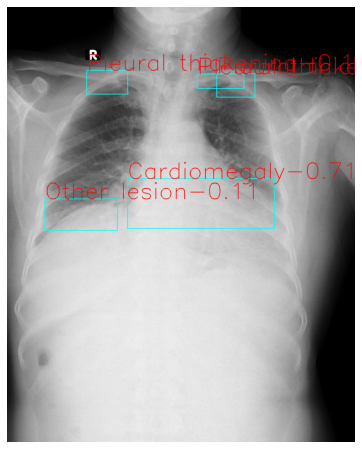

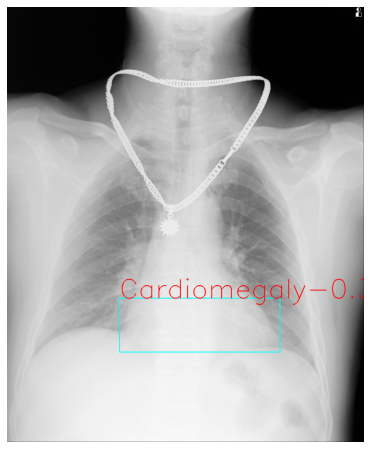

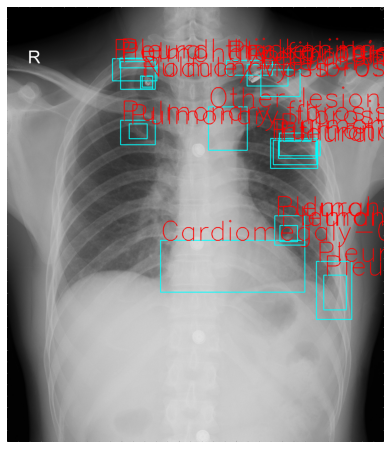

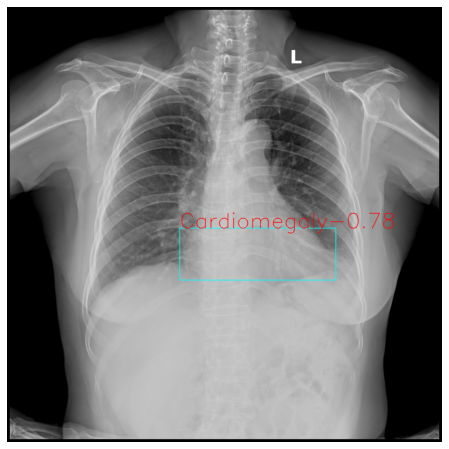

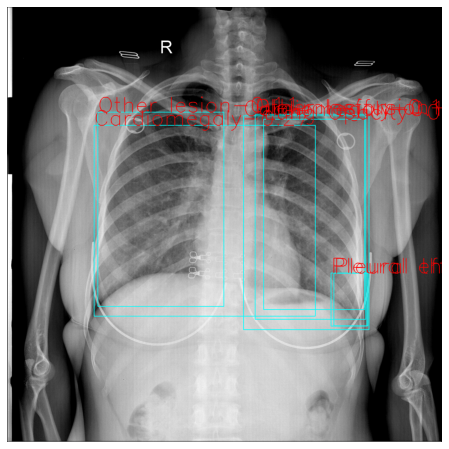

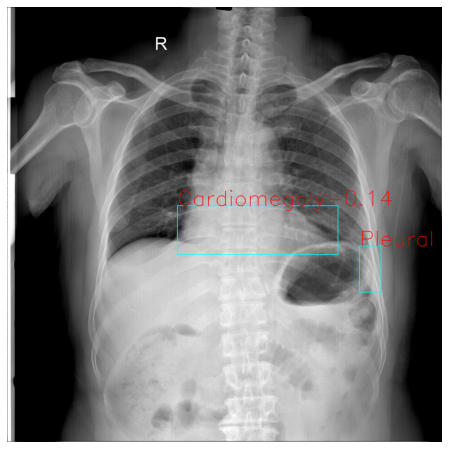

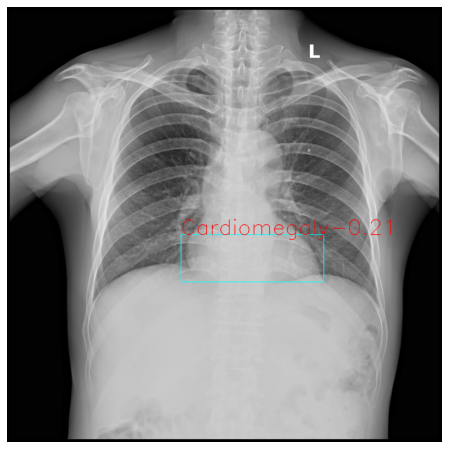

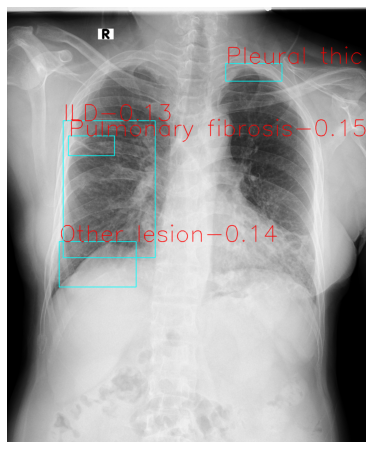

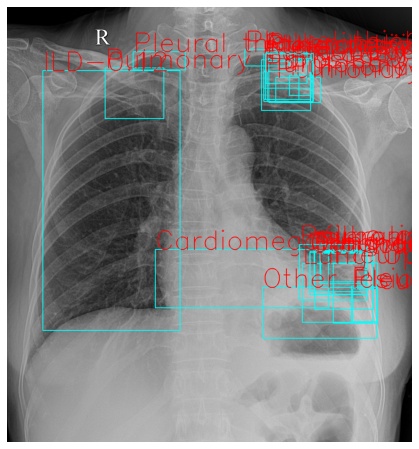

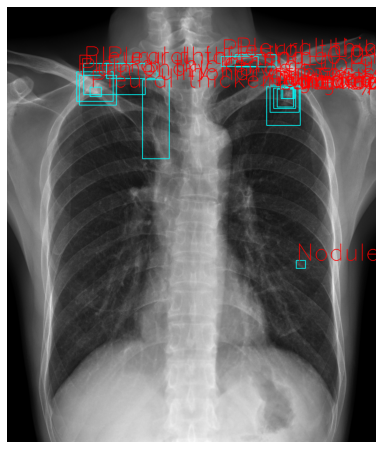

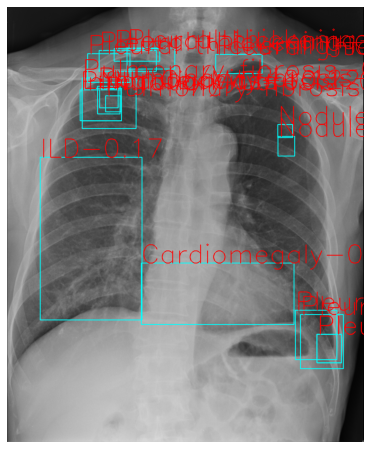

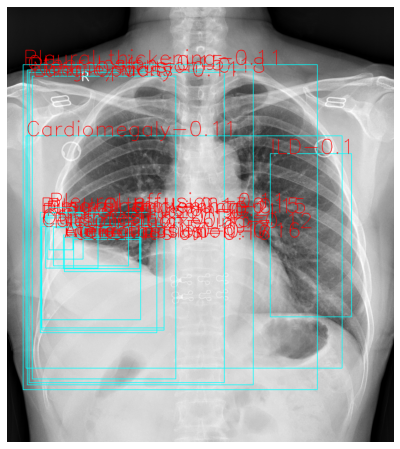

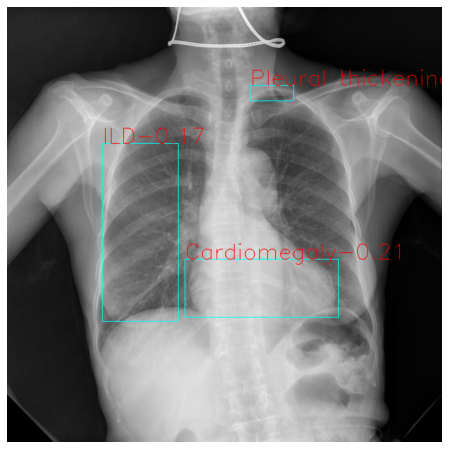

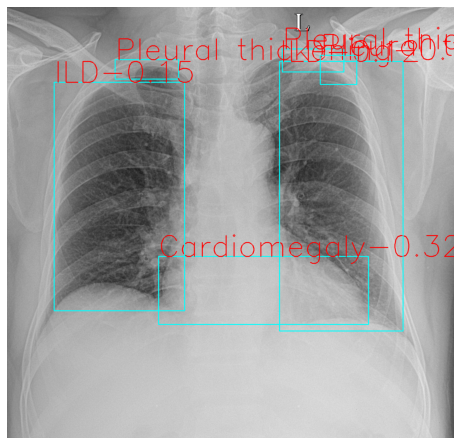

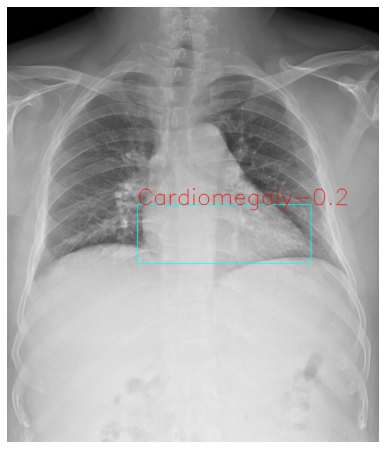

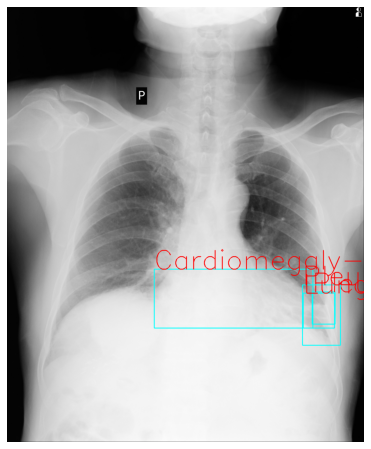

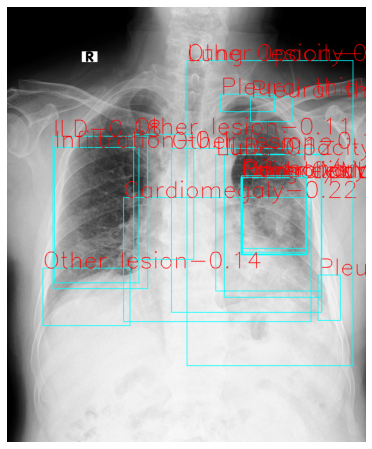

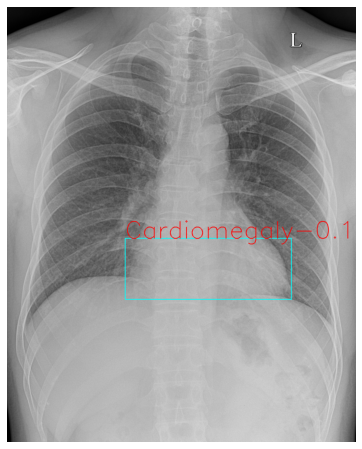

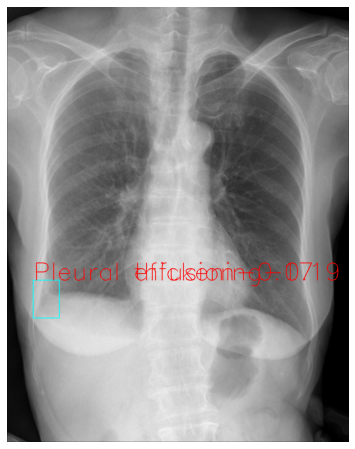

In [14]:
mapping = {0: 'Aortic enlargement', 1: 'Atelectasis', 2: 'Calcification', 3: 'Cardiomegaly', 4: 'Consolidation', 5: 'ILD',6: 'Infiltration', 7: 'Lung Opacity', 
           8: 'Nodule/Mass', 9: 'Other lesion', 10: 'Pleural effusion', 11: 'Pleural thickening',12: 'Pneumothorax', 13: 'Pulmonary fibrosis', 14: 'No finding'}

font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 5
thickness = 3
color = (1, 0, 0)

for j, (images, image_ids) in enumerate(data_loader):
    predictions = make_predictions(images, score_threshold=DETECTION_THRESHOLD)
    for i in range(len(predictions)):
        prediction = predictions[i]
        image_id = image_ids[i]
        
        if (len(prediction['scores'])>0):
            fig, ax = plt.subplots(1, 1, figsize=(8, 8))
            
            w, h = imagesize.get(f'{DATA_ROOT_PATH}/{image_id}.jpg')
            image = cv2.imread(f'{DATA_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR).copy().astype(np.float32)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
            image /= 255.0
            
            boxes, scores, labels = prediction['boxes'], prediction['scores'], prediction['labels']
            boxes, scores, labels = weighted_boxes_fusion([boxes], [scores], [labels], 
                                                          weights=None, 
                                                          iou_thr=iou_thr,
                                                          skip_box_thr=DETECTION_THRESHOLD)
            
            if (w > h):
                boxes[:, 0] = (boxes[:, 0] * w)
                boxes[:, 1] = (boxes[:, 1] * w) - (0.0 + w-h)/2
                boxes[:, 2] = (boxes[:, 2] * w)
                boxes[:, 3] = (boxes[:, 3] * w) - (0.0 + w-h)/2
            else:
                boxes[:, 0] = (boxes[:, 0] * h) - (0.0 + h-w)/2
                boxes[:, 1] = (boxes[:, 1] * h) 
                boxes[:, 2] = (boxes[:, 2] * h) - (0.0 + h-w)/2
                boxes[:, 3] = (boxes[:, 3] * h) 
        
            boxes = boxes.astype(np.int32)
            boxes[:, 0] = boxes[:, 0].clip(min=0, max=w-1)
            boxes[:, 2] = boxes[:, 2].clip(min=0, max=w-1)
            boxes[:, 1] = boxes[:, 1].clip(min=0, max=h-1)
            boxes[:, 3] = boxes[:, 3].clip(min=0, max=h-1)
            for score, box, label in zip(scores, boxes, labels):
                cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (0, 1, 1), thickness)
                cv2.putText(image, mapping[label] + "-" + str(round(score, 2)), (box[0], box[1]),
                        font, fontScale, color, thickness, cv2.LINE_AA)

            ax.set_axis_off()
            ax.imshow(image)
            plt.show()
    if j >= 10:
        break

In [ ]:
df = {'image_id': [],
      'class_id': [],
      'score':[],
      'x_min': [],
      'x_max': [],
      'y_min': [],
      'y_max': []}
for images, image_ids in tqdm(data_loader):
    predictions = make_predictions(images, score_threshold=DETECTION_THRESHOLD)
    
    for i in range(len(predictions)):
        prediction = predictions[i]
        image_id = image_ids[i]
        w, h = imagesize.get(f'{DATA_ROOT_PATH}/{image_id}.jpg')
        
        boxes, scores, labels = prediction['boxes'], prediction['scores'], prediction['labels']
        boxes, scores, labels = weighted_boxes_fusion([boxes], [scores], [labels], 
                                                          weights=None, 
                                                          iou_thr=iou_thr,
                                                          skip_box_thr=DETECTION_THRESHOLD)
        
        df['image_id'] += [image_id]*len(labels)
        df['class_id'] += labels.tolist()
        df['score'] += scores.tolist()
        df['x_min'] += boxes[:, 0].tolist()
        df['y_min'] += boxes[:, 1].tolist()
        df['x_max'] += boxes[:, 2].tolist()
        df['y_max'] += boxes[:, 3].tolist()

  2%|▏         | 13/750 [00:58<33:19,  2.71s/it]  

In [ ]:
!rm -rf omegaconf
!rm -rf timm-efficientdet-pytorch

In [ ]:
import pandas as pd
from tqdm import *
def to_submission(df, sample_file='sample_submission.csv', filename=None, trick=True):
    '''
    df: output dataframe
    sample_file: sample_submission file (to get image_id)
    filename: to csv file name
    trick: add class 14 to all images
    
    return a dataframe
    '''
    
    ss = pd.read_csv(sample_file)
    d = {i:[] for i in ss['image_id'].values.tolist()}
    sizemap = {i:(w,h) for i,w,h in zip(ss['image_id'].values.tolist(), ss['width'].values.tolist(), ss['height'].values.tolist())}
    trick_string = {i:' 14 '+str(s)+' 0 0 1 1' for i,s in zip(ss['image_id'].values.tolist(), ss['class14prob'].values.tolist())}
    
    image_id = []
    PredictionString = []
    for i in trange(len(df['image_id'].values.tolist())):
        w,h = sizemap[df['image_id'][i]]
        d[df['image_id'][i]].append(" ".join(map(str, [df['class_id'][i], df['score'][i], round(float(df['x_min'][i])*w), round(float(df['y_min'][i])*h), round(float(df['x_max'][i])*w), round(float(df['y_max'][i])*h)] )))
        
    for (k,v) in d.items():
        image_id.append(k)
        if (len(v) == 0): #case 14 1 0 0 1 1 not in df
            PredictionString.append(trick_string[k])
        elif (len(v) == 1 and v[0].startswith("14 ")): #case 14 x 0 0 1 1 in df
            PredictionString.append(" ".join(v[0].split()[:2])+' 0 0 1 1')
        else:
            PredictionString.append(" ".join(v) + int(trick)*trick_string[k])
    result = pd.DataFrame()
    result['image_id'] = image_id
    result['PredictionString'] = PredictionString
    
    result.sort_values('image_id', ignore_index=True,  inplace=True)
    
    if (filename):
        result.to_csv(filename, index = False)
    return result

In [ ]:
submission = to_submission(pd.DataFrame().from_dict(df), sample_file = '../input/2021-vin-2class/sample_submission.csv')
submission.head(10)